In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

In [2]:
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()

In [3]:
def fix_zip(series):
      return series.astype(str).str.replace('[^\w\s]', '').str.zfill(5)

In [4]:
mostly_clean_zori=pd.read_csv('./mostly_clean_zori.csv')
mostly_clean_zori.head(2)

,RegionName,Yr_Mo,RI,Year,Month,CountyName,zip_mean,zip_std,Outlier_High,Outlier_Low
0,10025,2014-01,2883.0,2014,1,New York County,2951.25,112.279389,False,False
1,10025,2014-02,2895.0,2014,2,New York County,2951.25,112.279389,False,False


In [5]:
#mostly_clean_zori[['RegionName','Yr_Mo','RI']]
mostly_clean_zori['RegionName']=fix_zip(mostly_clean_zori['RegionName'])
#mostly_clean_zori['RegionName']
pvt_tbl = mostly_clean_zori[['RegionName','Yr_Mo','RI']].pivot_table(columns='RegionName',values='RI',index='Yr_Mo',)

pvt_tbl.reset_index(inplace=True)
#pvt_tbl

In [6]:
train_lst = list(pvt_tbl['Yr_Mo'][:-17])
train_df = pvt_tbl[pvt_tbl['Yr_Mo'].isin(train_lst)]
train_df.set_index('Yr_Mo',drop=True,inplace=True)
test_df = pvt_tbl[~pvt_tbl['Yr_Mo'].isin(train_lst)]
test_df.set_index('Yr_Mo',drop=True,inplace=True)

#train_df
#test_df

xc = train_df[['10025','01603', '60657', '10023', '77494', '60614']]
yc = test_df[['10025','01603', '60657', '10023', '77494', '60614']]

### VAR Model

C:\Users\pengu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


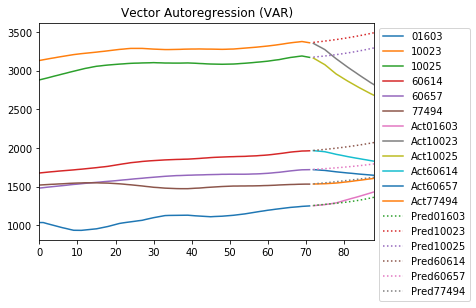

In [7]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

def VAR_model(train,test):
    # fit model
    model = VAR(train)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=len(test))
    res=pd.DataFrame({**dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
                                 [[x[i] for x in yhat] for i in range(len(yhat[0]))])),
                      **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).
                      reset_index(drop=True).to_dict('series')})
    return res, yhat
df_ret, yhat = VAR_model(xc, yc)

show_graph(xc, df_ret, "Vector Autoregression (VAR)")

### VARMA

In [11]:
model = VARMAX(xc, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast(steps=len(yc))

C:\Users\pengu\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\pengu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\pengu\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [12]:
yhat

,10025,01603,60657,10023,77494,60614
2020-01-01,3153.315340,1203.530324,1688.392338,3335.913977,1542.533231,1936.934527
2020-02-01,3115.926422,1101.558681,1639.360061,3305.663022,1578.834933,1876.535714
2020-03-01,3090.670817,1036.200236,1608.786695,3283.521697,1595.858110,1836.667797
2020-04-01,3076.974197,998.902978,1592.183190,3271.272992,1600.506526,1813.775526
2020-05-01,3070.982518,981.433632,1584.799534,3265.592014,1596.866436,1802.637866
2020-06-01,3069.994865,977.020666,1583.272932,3264.172139,1588.581346,1799.273224
2020-07-01,3071.978443,980.395027,1585.154472,3265.303149,1578.383601,1800.644894
2020-08-01,3075.464113,987.738681,1588.726601,3267.757852,1568.093768,1804.543874
2020-09-01,3079.456777,996.482492,1592.854737,3270.705735,1558.780311,1809.458710
2020-10-01,3083.336847,1005.043772,1596.849033,3273.627119,1550.955766,1814.431760


C:\Users\pengu\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


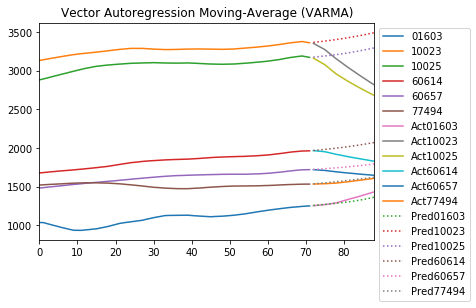

,Pred10025,Pred01603,Pred60657,Pred10023,Pred77494,Pred60614,Act10025,Act01603,Act60657,Act10023,Act77494,Act60614
0,3177.928561,1258.397819,1724.941424,3368.009981,1538.722807,1970.178891,3165.0,1256.0,1722.0,3355.0,1536.0,1968.0
1,3182.220709,1263.450036,1728.030350,3373.312147,1542.746526,1974.570807,3137.0,1261.0,1719.0,3328.0,1537.0,1963.0
2,3186.890857,1268.257678,1731.264709,3378.913605,1547.057228,1979.184069,3108.0,1265.0,1715.0,3302.0,1539.0,1959.0
3,3191.953748,1272.930354,1734.645325,3384.822858,1551.635444,1984.027941,3080.0,1270.0,1712.0,3275.0,1540.0,1954.0
4,3197.423675,1277.582151,1738.175877,3391.049282,1556.457202,1989.112603,3040.0,1277.0,1706.0,3235.0,1543.0,1943.0


In [8]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

def VARMA_model(train,test):
    # fit model
    model = VARMAX(train, order=(1, 1))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=len(test))
    res=pd.DataFrame({**dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
                                 [[x[i] for x in yhat] for i in range(len(yhat[0]))])),
                      **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).
                      reset_index(drop=True).to_dict('series')})
    return res, yhat
df_ret, yhat = VAR_model(xc, yc)

show_graph(xc, df_ret, "Vector Autoregression Moving-Average (VARMA)")
df_ret.head()

In [15]:
yhat.reset_index(drop=True)
yhat

,10025,01603,60657,10023,77494,60614
2020-01-01,3153.315340,1203.530324,1688.392338,3335.913977,1542.533231,1936.934527
2020-02-01,3115.926422,1101.558681,1639.360061,3305.663022,1578.834933,1876.535714
2020-03-01,3090.670817,1036.200236,1608.786695,3283.521697,1595.858110,1836.667797
2020-04-01,3076.974197,998.902978,1592.183190,3271.272992,1600.506526,1813.775526
2020-05-01,3070.982518,981.433632,1584.799534,3265.592014,1596.866436,1802.637866
2020-06-01,3069.994865,977.020666,1583.272932,3264.172139,1588.581346,1799.273224
2020-07-01,3071.978443,980.395027,1585.154472,3265.303149,1578.383601,1800.644894
2020-08-01,3075.464113,987.738681,1588.726601,3267.757852,1568.093768,1804.543874
2020-09-01,3079.456777,996.482492,1592.854737,3270.705735,1558.780311,1809.458710
2020-10-01,3083.336847,1005.043772,1596.849033,3273.627119,1550.955766,1814.431760


### VARMAX Model

In [22]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

def VARMAX_model(train,test):
    # fit model
    model = VARMAX(train.drop('Exog', axis=1), exog=train['Exog'], order=(1, 1))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=len(test),exog=test['Exog'])
    res=pd.DataFrame({"Pred1":yhat['Act1'], "Pred2":yhat['Act2'], 
            "Act1":test["Act1"].values, "Act2":test["Act2"].values, "Exog":test["Exog"].values})
    return res

In [25]:
df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
                         'Act2':[x*3 + random()*10 for x in range(0, 100)],
                         'Exog':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
df_train.head()

,Act1,Act2,Exog
0,5.393178,3.392797,50.000000
1,2.521827,3.022559,53.171196
2,4.673243,11.835146,56.329623
3,12.359196,15.225292,59.462562
4,4.145996,17.462699,62.557399


In [26]:
df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
                         'Act2':[x*3 + random()*10 for x in range(101, 201)],
                         'Exog':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
df_train.head()

,Act1,Act2,Exog
0,5.393178,3.392797,50.000000
1,2.521827,3.022559,53.171196
2,4.673243,11.835146,56.329623
3,12.359196,15.225292,59.462562
4,4.145996,17.462699,62.557399


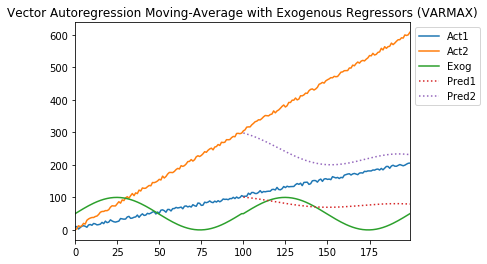

In [21]:
df_ret = VARMAX_model(df_train, df_test)
show_graph(df_train, df_ret,"Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)")

In [31]:
x_list = []

x = pd.DataFrame({'Exog':50+np.sin(np.linspace(0, 2*np.pi, 100))*50,
                 'Exog':100+np.sin(np.linspace(0, 2*np.pi, 100))*100})

for q in range(5):
    x_lagged = x.shift(q).bfill()
    x_list.append(x_lagged)
    
x_lag = pd.concat(x_list,axis=1)

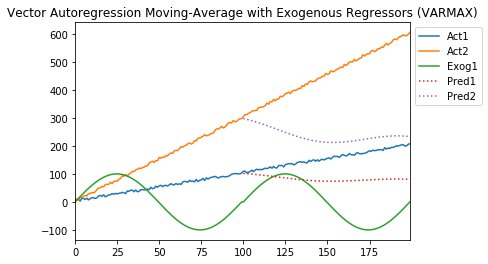

In [80]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

def VARMAX_model(train,test):
    # fit model
    model = VARMAX(train.drop('Exog1', axis=1), exog=train['Exog1'], order=(1, 2))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=len(test),exog=test['Exog1'])
    res=pd.DataFrame({"Pred1":yhat['Act1'], "Pred2":yhat['Act2'],
                      "Act1":test["Act1"].values, "Act2":test["Act2"].values,
                      "Exog1":test["Exog1"].values})#, "Exog2":test["Exog2"].values})
    return res

df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
                         'Act2':[x*3 + random()*10 for x in range(0, 100)],
#                         'Exog1':50+np.sin(np.linspace(0, 2*np.pi, 100))*50,
                         'Exog1':1+np.sin(np.linspace(0, 2*np.pi, 100))*100})
#                         'Exog1':10+np.sin(np.linspace(0, 2*np.pi, 100))*100})
df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
                         'Act2':[x*3 + random()*10 for x in range(101, 201)],
#                         'Exog1':50+np.sin(np.linspace(0, 2*np.pi, 100))*50,
                         'Exog1':1+np.sin(np.linspace(0, 2*np.pi, 100))*100})
#                         'Exog1':10+np.sin(np.linspace(0, 2*np.pi, 100))*100})

df_ret = VARMAX_model(df_train, df_test)
show_graph(df_train, df_ret,"Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)")

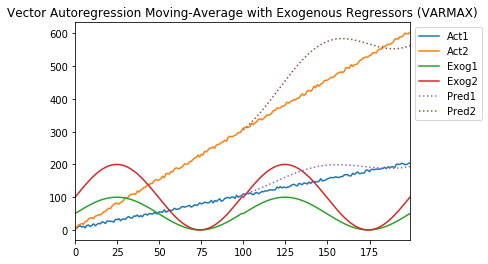

In [82]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

def VARMAX_model(train,test):
    # fit model
    model = VARMAX(train.drop(['Exog1', 'Exog2'], axis=1), exog=train[['Exog2', 'Exog1']], order=(1, 1))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=len(test),exog=test[['Exog1', 'Exog2']])
    res=pd.DataFrame({"Pred1":yhat['Act1'], "Pred2":yhat['Act2'],
                      "Act1":test["Act1"].values, "Act2":test["Act2"].values,
                      "Exog1":test["Exog1"].values, "Exog2":test["Exog2"].values})
    return res

df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
                         'Act2':[x*3 + random()*10 for x in range(0, 100)],
                         'Exog1':50+np.sin(np.linspace(0, 2*np.pi, 100))*50,
                         'Exog2':100+np.sin(np.linspace(0, 2*np.pi, 100))*100})
df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
                         'Act2':[x*3 + random()*10 for x in range(101, 201)],
                         'Exog1':50+np.sin(np.linspace(0, 2*np.pi, 100))*50,
                         'Exog2':100+np.sin(np.linspace(0, 2*np.pi, 100))*100})

df_ret = VARMAX_model(df_train, df_test)
show_graph(df_train, df_ret,"Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)")